In [10]:
import numpy as np
import soundfile as sf
import noisereduce as nr
import librosa
import birdnetlib
import os 
import matplotlib.pyplot as plt
import pandas as pd
import shutil
from collections import Counter
from tensorflow.lite.python.interpreter import Interpreter
from pprint import pprint 


In [11]:
from birdnetlib import Recording
from birdnetlib.analyzer import Analyzer
from birdnetlib.batch import DirectoryMultiProcessingAnalyzer
from birdnetlib.species import SpeciesList
from birdnetlib.watcher import DirectoryWatcher
from datetime import datetime 
import re 
import csv 

In [12]:
metadata_df = pd.read_csv("metadata.csv")
metadata_df["Date"] = pd.to_datetime(metadata_df["Date"], dayfirst=True)

def get_file_metadata(filename, df):
    date_match = re.search(r'_(\d{8})_(\d{6})', filename)
    if not date_match:
        return None, None, None

    dt = datetime.strptime(
        date_match.group(1) + date_match.group(2),
        "%Y%m%d%H%M%S"
    )

    if dt.hour < 6: 
        recording_date = (dt.date() + pd.Timedelta(days=1))
    else:
        recording_date = dt.date()

    station_match = re.search(r'(\d+_S\d+)', filename)
    if not station_match:
        return None, None, None

    station_id = station_match.group(1)

    matches = df[
        (df["Device Code"] == station_id) &
        (df["Date"].dt.date == recording_date)
    ]

    if matches.empty:
        return None, None, None

    row = matches.iloc[0]
    return row["Latitude"], row["Longitude"], row["Time"]


In [13]:
def clear_directory(dir_path):
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path) # remove every file in a given directory
    os.mkdir(dir_path)

In [14]:
def extract_file_date(filename):
    pattern = r"(\d{8})[_-](\d{6})" # search for pattern in file name of year/month/day_hour/minute/second
    match = re.search(pattern, filename)
    date, time = match.groups()
    return datetime.strptime(date + time, "%Y%m%d%H%M%S")

In [15]:
def print_file_detections(recording):
    print("\n" + recording.path)
    pprint(recording.date)
    print("predicted species: \n")
    lat, lon, day_or_night = get_file_metadata(os.path.basename(recording.path), metadata_df)
    species_pred = SpeciesList() 
    species_predicted = species_pred.return_list(lon=lon, lat=lat, 
                                                    date=recording.date, threshold=0.75) 
    pprint(species_predicted)
    print("detected species: \n")
    pprint(recording.detections)

In [16]:
def analyse_file():
    
    analysers = {
        "default" : Analyzer(),
        "full_species" : Analyzer(custom_species_list="species_lists/full_species_list.txt"),
        "main_species" : Analyzer(custom_species_list="species_lists/main_species_list.txt"),
    }
    
    analyser_colours = {
        "default" : "black",
        "full_species" : "red", 
        "main_species" : "cyan",
    }
    
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    
    export_directory = f"extractions/high_conf_{timestamp}"
    os.makedirs(export_directory, exist_ok=True) # set exist_ok = true to suppress error even if directory already exists 
    
    csv_path = os.path.join(export_directory, f"detections_{timestamp}.csv") # put csv of detections in same directory as corresponding extractions
    csv_headers = [
        "file_name", "best_analyzer", "common_name", "scientific_name",
        "confidence", "start_time", "end_time", "audio_path",
        "spectrogram_path", "lat", "lon", "date", "day_or_night", "in_full_species_list"
    ]
    
    # load in full species set for filtering (scientific names only)
    with open("species_lists/full_species_list.txt", "r", encoding="utf-8") as f:
        full_species_set = set()
        for line in f:
            line = line.strip()
            if line:
                parts = line.split("_", 1)  # split into scientific and common name
                if len(parts) == 2:
                    scientific_name = parts[0].strip().lower()
                    full_species_set.add(scientific_name)


    
    with open(csv_path, mode="w", newline="", encoding="utf-8") as csv_file: # w = write mode 
        writer = csv.DictWriter(csv_file, fieldnames=csv_headers)
        writer.writeheader() # writes header row to csv
    
        file_directory = "aru"
        
        file_paths = [os.path.join(file_directory, f) for f in os.listdir(file_directory)
            if f.lower().endswith((".wav", ".mp3"))] # store full path for every file in aru directory 
        
        for file_path in file_paths:
            file_name = os.path.basename(file_path)
            file_date = extract_file_date(file_name)
            lat, lon, day_or_night = get_file_metadata(file_name, metadata_df)
            print(f"\nanalysing {file_name} ({day_or_night}) at lat {lat} and lon {lon}")
            
            file_detections = [] # association list of all detections in a file with what analyser they used 
            
            for analyser_name, analyser in analysers.items():
                try: 
                    if analyser.has_custom_species_list: # analyser with custom species list cannot use lat, lon
                        recording = Recording(
                            analyzer=analyser, 
                            path=file_path,
                            date=file_date,
                            min_conf=0.95,
                            return_all_detections=True
                        )
                    else:
                        recording = Recording(
                            analyzer=analyser, 
                            path=file_path,
                            date=file_date,
                            lat=lat,
                            lon=lon, 
                            min_conf=0.95,
                            return_all_detections=True
                        )
                    
                    recording.analyze() 
                    for detection in recording.detections:
                        detection["analyser"] = analyser_name
                        detection["recording"] = recording
                        file_detections.append(detection)
                except Exception as e:
                    print(f"analysis of {file_name} using {analyser_name} failed with: {e}")
                    
            best_file_detections = {}
            for detection in file_detections:
                species_name = detection.get("common_name")
                species_detected = (species_name, round(detection.get("start_time"), 2)) # round detection start time to 2 decimal places
                if (species_detected not in best_file_detections) or (detection["confidence"] > best_file_detections[species_detected]["confidence"]):
                    best_file_detections[species_detected] = detection # if this detection has the highest confidence value for this snippet, store this
                    
            for species in best_file_detections.keys():
                detection = best_file_detections[species]
                if detection["analyser"] == "default":
                    species_name = detection.get("common_name")
                    for specific_analyser in ["main_species", "full_species"]: # main > full > default in priority (of specialisation)
                        for detect in file_detections:
                            if (detect["analyser"] == specific_analyser) and (detect.get("common_name") == species_name):
                                best_file_detections[species] = detect # if there is a detection in main then use that, if not if there is one in full use that, otherwise stay with default
                                break

            for detection in best_file_detections.values(): # extracting (species, start time) for highest confidence clips
                scientific_name_clean = detection.get("scientific_name", "").strip().lower()
                common_name_clean = detection.get("common_name", "").strip()
                
                in_full_species_list = scientific_name_clean in full_species_set
                if not in_full_species_list:
                    print(f"including {common_name_clean} ({scientific_name_clean} not in full species list)")
                    continue 
                else:
                    print(f"keeping {common_name_clean} [{detection.get('scientific_name', '')}]")
                    #continue

                
                recording = detection["recording"]
                species_name = re.sub(r"[^a-zA-Z0-9_]", "_", detection.get("common_name")) # if the common name has weird things in it, replace with _ 
                
                species_directory = os.path.join(export_directory, species_name)
                os.makedirs(species_directory, exist_ok=True) # make directories to store species detections by file name 
                
                try:
                    recording.extract_detections_as_audio(directory=species_directory, format="mp3", min_conf=0.95, padding_secs=2)
                    recording.extract_detections_as_spectrogram(directory=species_directory, min_conf=0.95, padding_secs=2)
                    
                    writer.writerow({
                        "file_name" : file_name, 
                        "best_analyzer" : detection["analyser"], 
                        "common_name" : detection["common_name"], 
                        "scientific_name" : detection["scientific_name"],
                        "confidence" : detection["confidence"], 
                        "start_time" : detection["start_time"], 
                        "end_time" : detection["end_time"], 
                        "audio_path" : species_directory,
                        "spectrogram_path" : species_directory, 
                        "lat" : lat, 
                        "lon" : lon, 
                        "date" : file_date.strftime("%Y-%m-%d"), 
                        "day_or_night": day_or_night,
                        "in_full_species_list" : in_full_species_list,
                    })
                except Exception as e:
                    print(f"extraction of {file_name} using failed with: {e}")
                    
    return csv_path

In [17]:
def visualise_detections(csv_path):
    df = pd.read_csv(csv_path)

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    species_counts = df['common_name'].value_counts()
    species_counts.plot(kind='bar', color='skyblue', ax=axes[0])
    axes[0].set_title("species distribution")
    axes[0].set_ylabel("number of detections")
    axes[0].set_xlabel("species")
    axes[0].tick_params(axis='x', rotation=45)
        
    day_night_counts = df['day_or_night'].value_counts()
    axes[1].pie(day_night_counts, labels=day_night_counts.index, autopct='%1.1f%%',
                colors=['gold', 'navy'], startangle=90)
    axes[1].set_title("day vs night detections")
    
    axes[2].scatter(df['lon'], df['lat'], c='green', alpha=0.6)
    axes[2].set_title("detections by location")
    axes[2].set_xlabel("longitude")
    axes[2].set_ylabel("latitude")
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()

Labels loaded.
load model True
Model loaded.
Labels loaded.
load_species_list_model


/Users/anku2024/Documents/clink lab/boeung-sne/birdc/lib/python3.9/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Meta model loaded.
Labels loaded.
load model True
Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.
Labels loaded.
load model True
Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.

analysing 3_S7901_20250204_134500_UTC_7_.wav (8:00 am to 5:00 pm) at lat 11.403694 and lon 105.398278
read_audio_data
read_audio_data: complete, read  200 chunks.
analyze_recording 3_S7901_20250204_134500_UTC_7_.wav
recording has lon/lat
set_predicted_species_list_from_position
return_predicted_species_list
5
511 species loaded.
read_audio_data
read_audio_data: complete, read  200 chunks.
analyze_recording 3_S7901_20250204_134500_UTC_7_.wav
read_audio_data
read_audio_data: complete, read  200 chunks.
analyze_recording 3_S7901_20250204_134500_UTC_7_.wav

analysing 3_S7901_20250204_064500_UTC_7_.wav (8:00 am to 5:00 pm) at lat 11.403694 and lon 105.398278
read_audio_data
read_audio_data: complete, read  200 chunks.
analyze_recording 3_S7901_20250204_064500_UTC_7_.wa

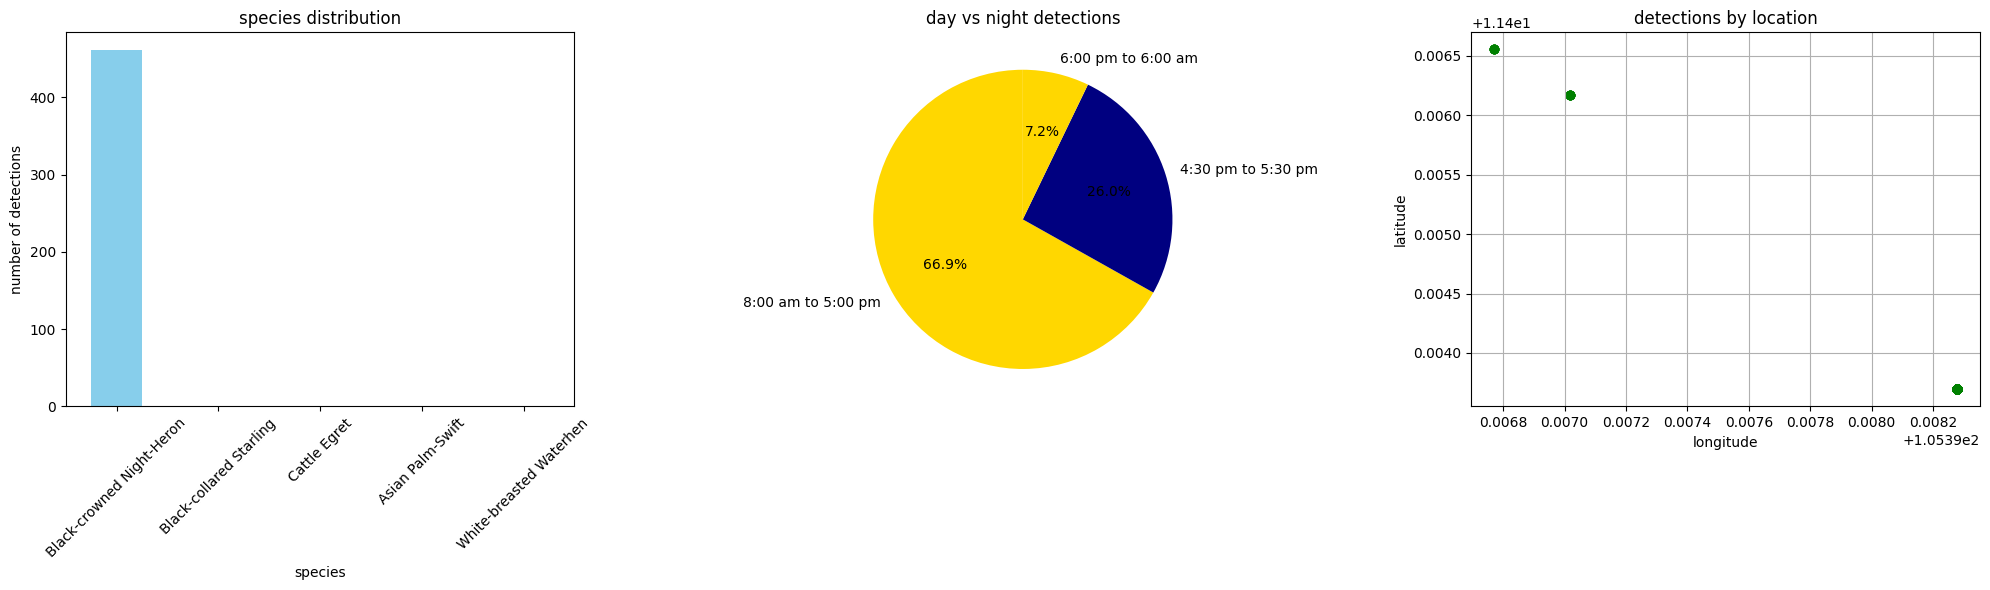

In [18]:
csv_path = analyse_file()
visualise_detections(csv_path)